In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.5/442.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 2.9 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (122/122), done.
remote

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [23]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'Word-Embedding-GPT3-adda',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "batch_size": 32,
    # model configs
    "d_model": 256, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_word_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/Word_Embedding/ada_002_embs.pickle'
with open(I3D_data_path, "rb") as pf:
    word_dict = pickle.load(pf)

# GloVe quirks
# word_dict['nordic walking'] = word_dict['fitness walking']
# word_dict['watching tv'] = word_dict['watching television']

In [11]:
# re-arrange semantic space 
# semantic_space = np.array([word_dict[c.lower()] for c in actionList])
semantic_space = np.array([word_dict[c] for c in actionList])[:, :config['feat_size']]

In [12]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes).float()
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [13]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

---

In [14]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [16]:
def loss_cross_entropy(y_pred, cls, selected_features, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    return loss

def newLoss(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [17]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [18]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

In [19]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [20]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [21]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-21-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-54


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

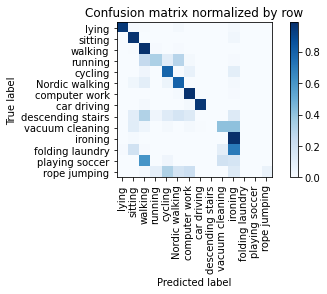

Overall accuracy: 0.736



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

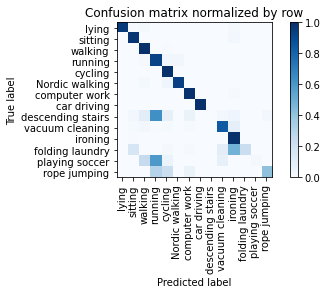

Overall accuracy: 0.855



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

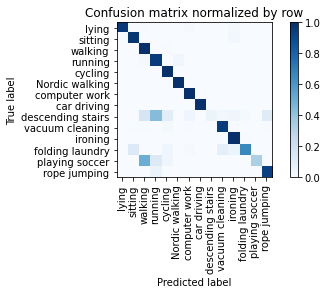

Overall accuracy: 0.916



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

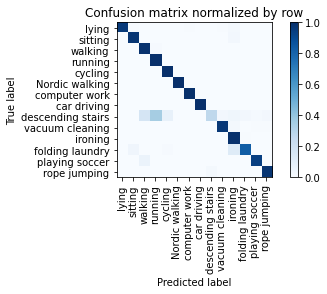

Overall accuracy: 0.950



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

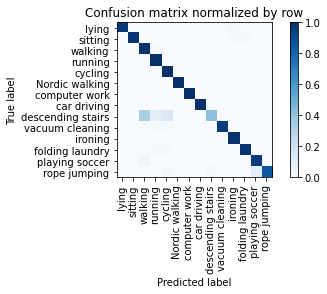

Overall accuracy: 0.959



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

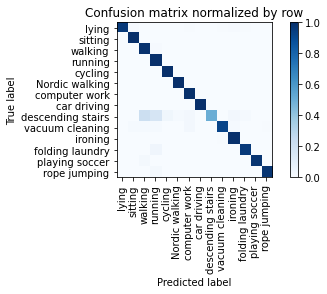

Overall accuracy: 0.965



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

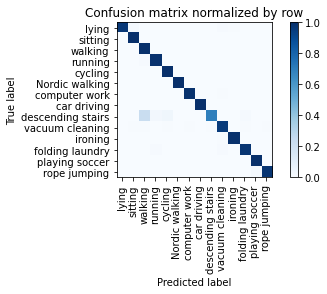

Overall accuracy: 0.977



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

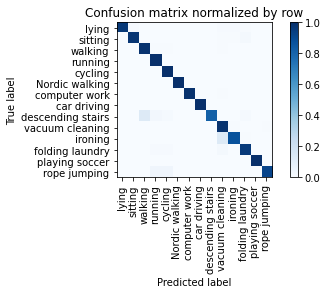

Overall accuracy: 0.965



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

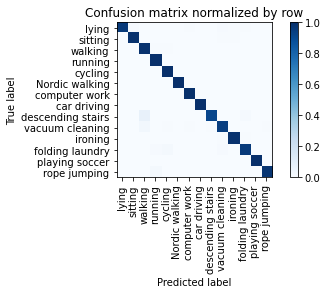

Overall accuracy: 0.982



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

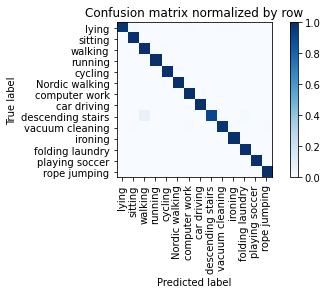

Overall accuracy: 0.990



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

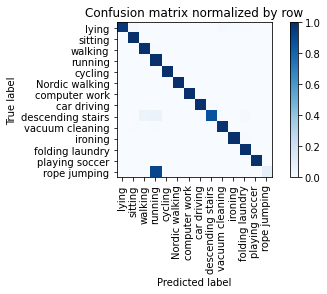

Overall accuracy: 0.968



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

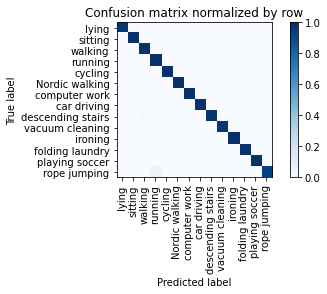

Overall accuracy: 0.991



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

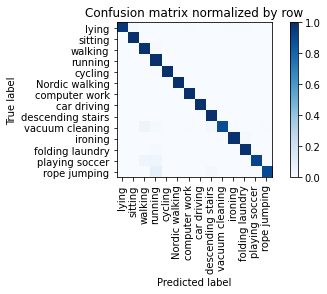

Overall accuracy: 0.979



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

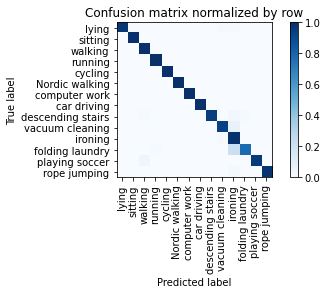

Overall accuracy: 0.975



train:   0%|          | 0/565 [00:00<?, ?batch/s]

seen:   0%|          | 0/62 [00:00<?, ?batch/s]

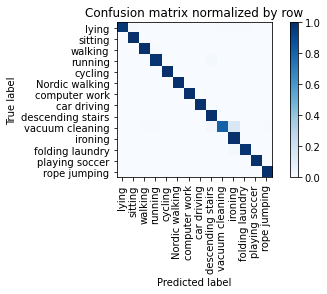

Overall accuracy: 0.978



unseen:   0%|          | 0/166 [00:00<?, ?batch/s]

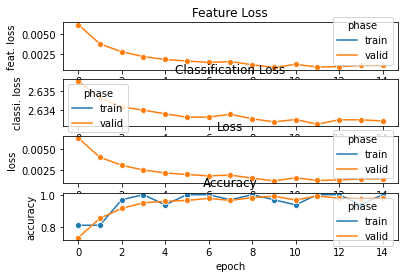

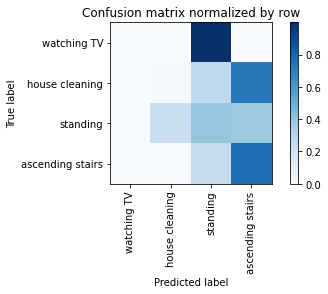

Overall accuracy: 0.269

{'accuracy': 0.26901355421686746, 'precision': 0.16005953306052845, 'recall': 0.2927489067730995, 'f1': 0.19148488754774903, 'samples': 5312, 'loss': 69.25216776132584, 'feat. loss': 68.51561585068703, 'classi. loss': 7365.518974304199}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
seen classes >  [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
unseen classes >  [3, 17, 1, 11]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

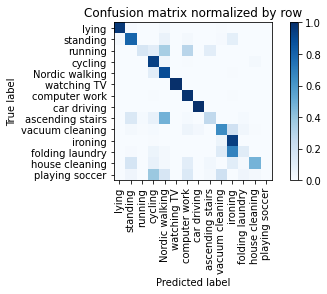

Overall accuracy: 0.742



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

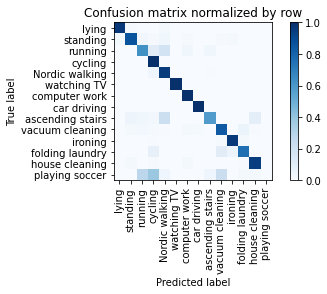

Overall accuracy: 0.884



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

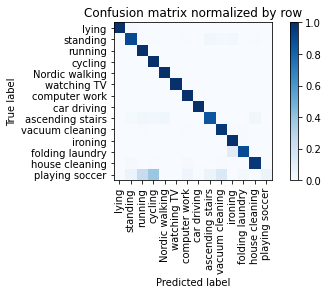

Overall accuracy: 0.949



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

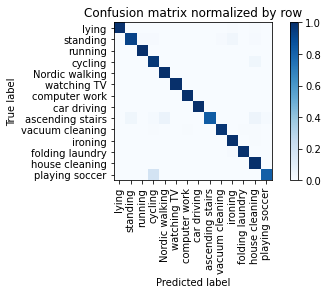

Overall accuracy: 0.975



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

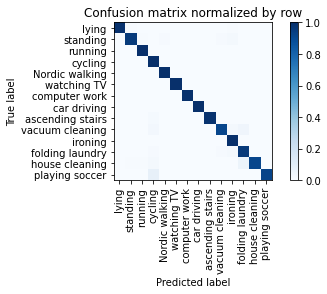

Overall accuracy: 0.976



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

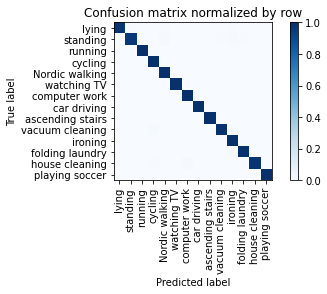

Overall accuracy: 0.992



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

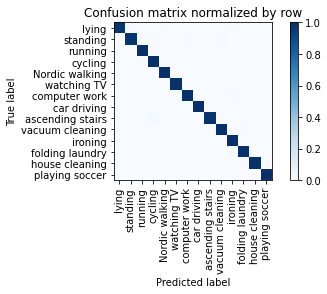

Overall accuracy: 0.994



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

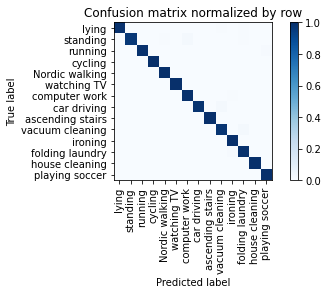

Overall accuracy: 0.992



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

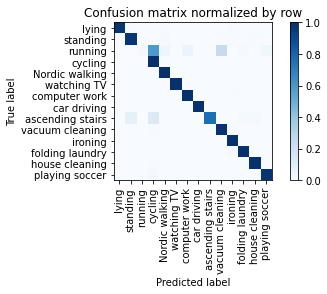

Overall accuracy: 0.931



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

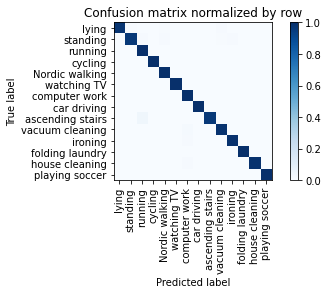

Overall accuracy: 0.990



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

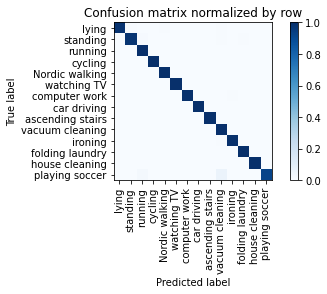

Overall accuracy: 0.993



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

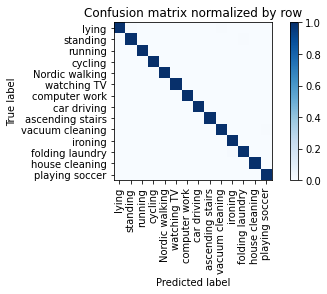

Overall accuracy: 0.997



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

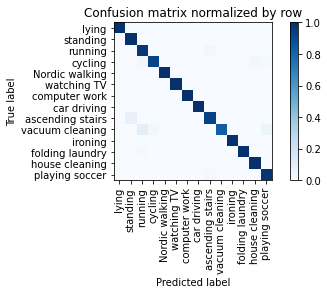

Overall accuracy: 0.973



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

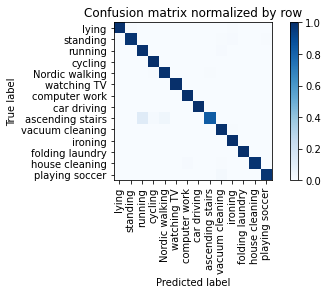

Overall accuracy: 0.986



train:   0%|          | 0/567 [00:00<?, ?batch/s]

seen:   0%|          | 0/63 [00:00<?, ?batch/s]

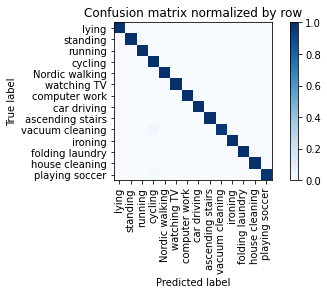

Overall accuracy: 0.995



unseen:   0%|          | 0/163 [00:00<?, ?batch/s]

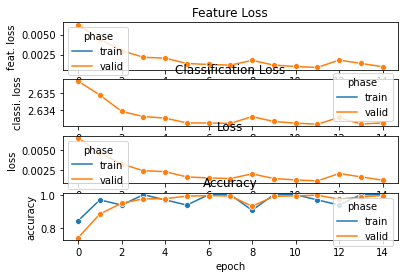

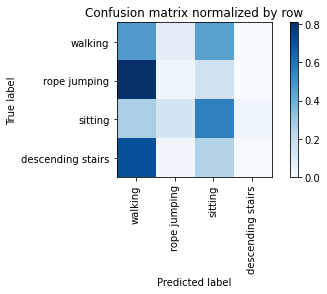

Overall accuracy: 0.391

{'accuracy': 0.3907208588957055, 'precision': 0.25360301947572517, 'recall': 0.267329484676063, 'f1': 0.24645330522372563, 'samples': 5216, 'loss': 63.60585418343544, 'feat. loss': 62.88303542137146, 'classi. loss': 7228.188453674316}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
seen classes >  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17]
unseen classes >  [16, 0, 12, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

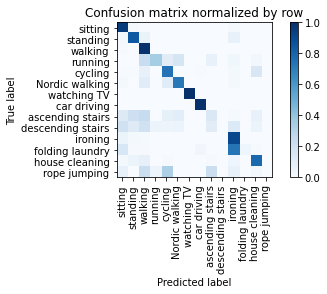

Overall accuracy: 0.714



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

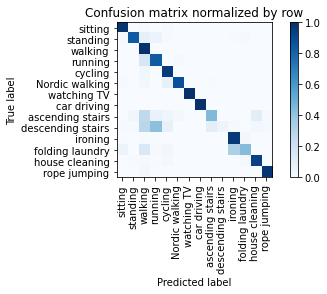

Overall accuracy: 0.850



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

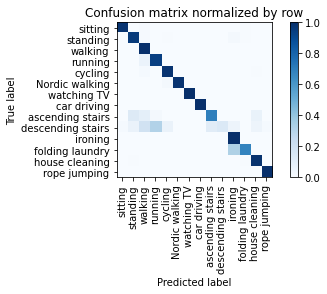

Overall accuracy: 0.918



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

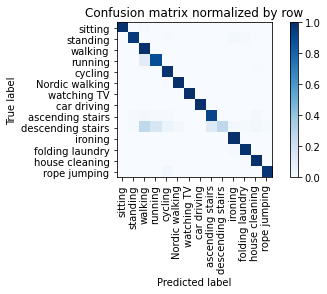

Overall accuracy: 0.951



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

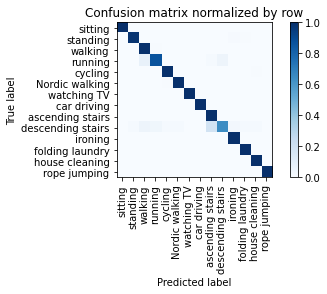

Overall accuracy: 0.975



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

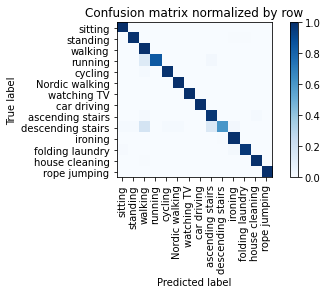

Overall accuracy: 0.969



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

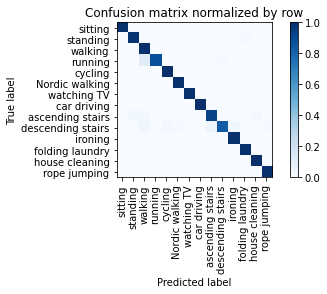

Overall accuracy: 0.981



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

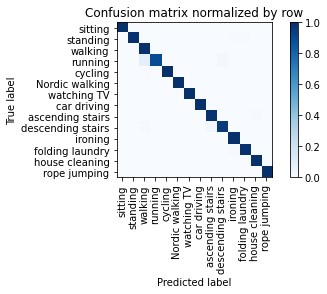

Overall accuracy: 0.991



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

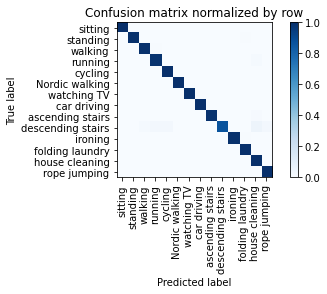

Overall accuracy: 0.991



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

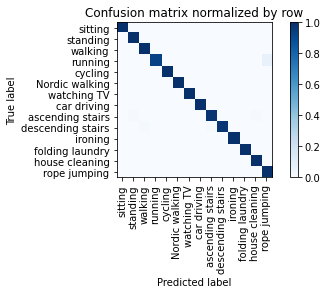

Overall accuracy: 0.995



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

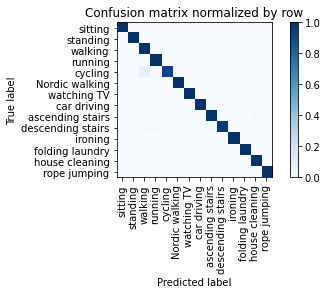

Overall accuracy: 0.989



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

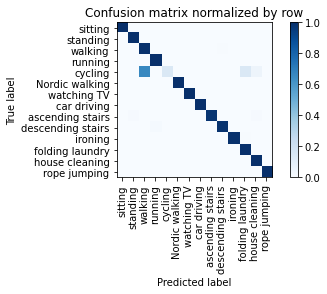

Overall accuracy: 0.919



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

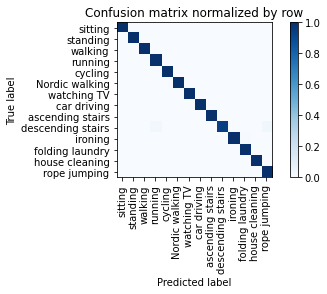

Overall accuracy: 0.997



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

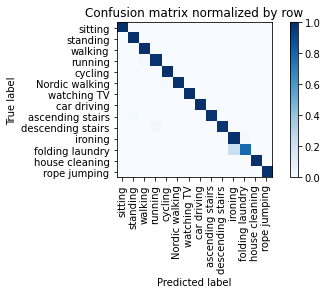

Overall accuracy: 0.985



train:   0%|          | 0/520 [00:00<?, ?batch/s]

seen:   0%|          | 0/57 [00:00<?, ?batch/s]

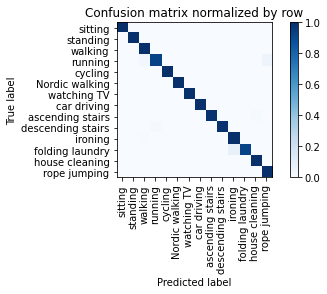

Overall accuracy: 0.991



unseen:   0%|          | 0/216 [00:00<?, ?batch/s]

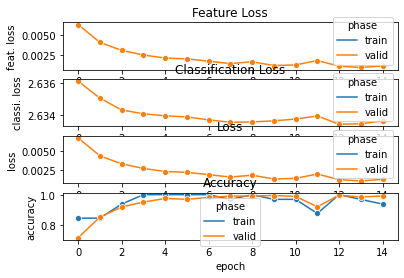

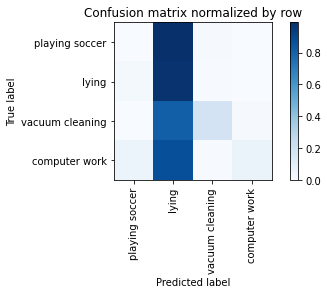

Overall accuracy: 0.324

{'accuracy': 0.3236400462962963, 'precision': 0.5284624845825596, 'recall': 0.30432740957973736, 'f1': 0.21484161000089835, 'samples': 6912, 'loss': 88.76681137084961, 'feat. loss': 87.80882751941681, 'classi. loss': 9579.837928771973}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
unseen classes >  [5, 4, 6]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

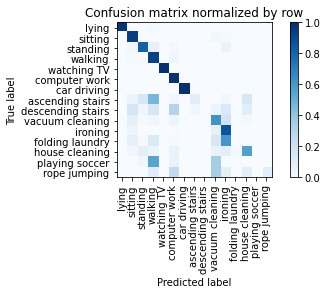

Overall accuracy: 0.723



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

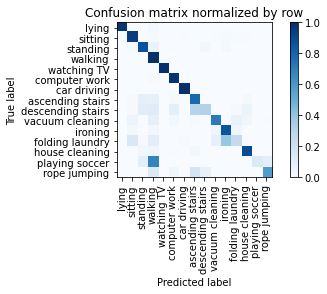

Overall accuracy: 0.839



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

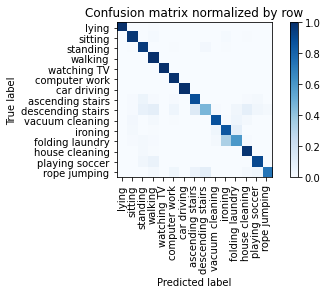

Overall accuracy: 0.910



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

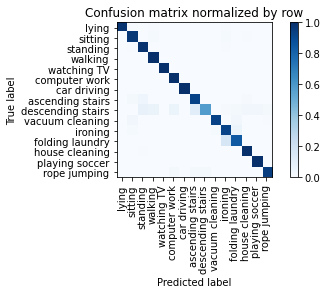

Overall accuracy: 0.950



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

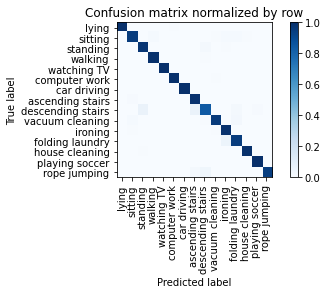

Overall accuracy: 0.976



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

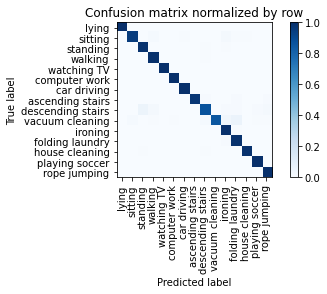

Overall accuracy: 0.975



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

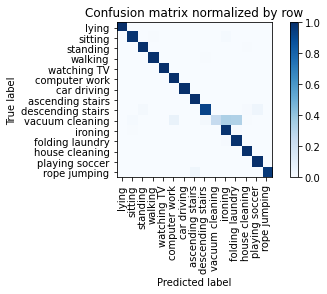

Overall accuracy: 0.938



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

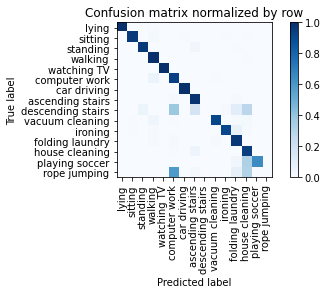

Overall accuracy: 0.888



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

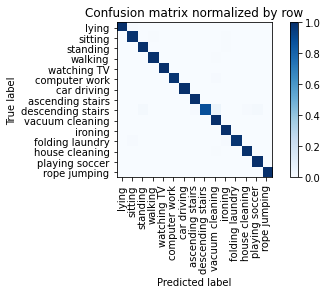

Overall accuracy: 0.988



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

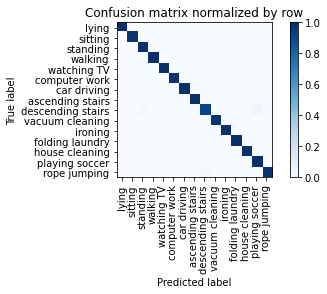

Overall accuracy: 0.991



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

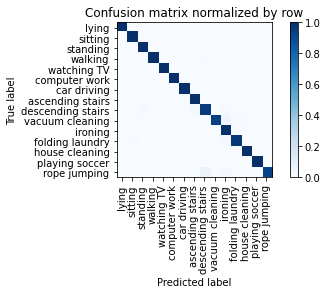

Overall accuracy: 0.989



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

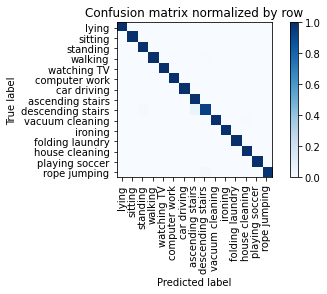

Overall accuracy: 0.995



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

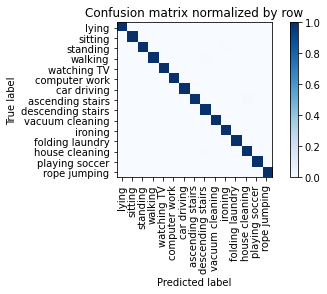

Overall accuracy: 0.998



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

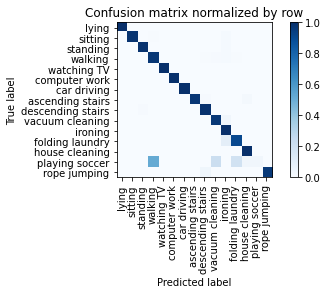

Overall accuracy: 0.970



train:   0%|          | 0/597 [00:00<?, ?batch/s]

seen:   0%|          | 0/66 [00:00<?, ?batch/s]

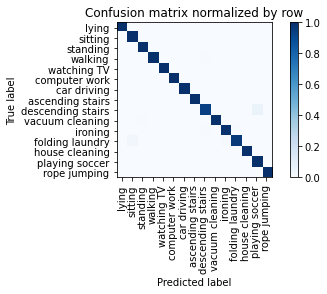

Overall accuracy: 0.993



unseen:   0%|          | 0/131 [00:00<?, ?batch/s]

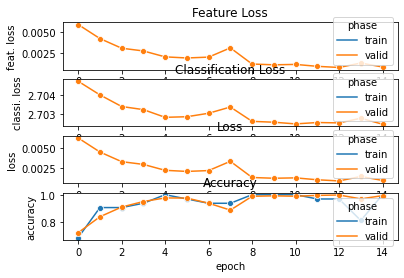

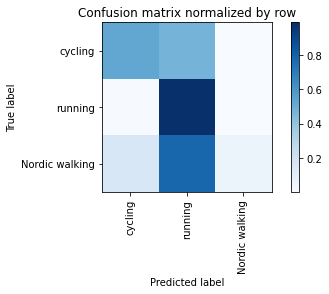

Overall accuracy: 0.430

{'accuracy': 0.4301049618320611, 'precision': 0.6598002556874176, 'recall': 0.5267872916129205, 'f1': 0.39640908300578764, 'samples': 4192, 'loss': 54.21111059188843, 'feat. loss': 53.75059771537781, 'classi. loss': 4605.129180908203}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

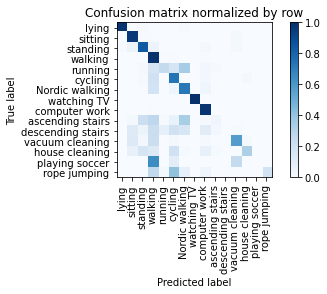

Overall accuracy: 0.704



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

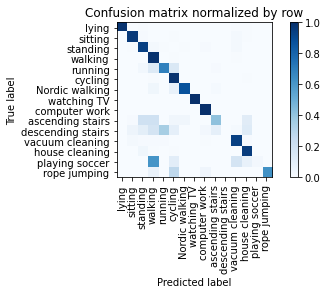

Overall accuracy: 0.867



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

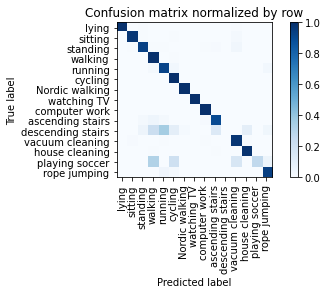

Overall accuracy: 0.926



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

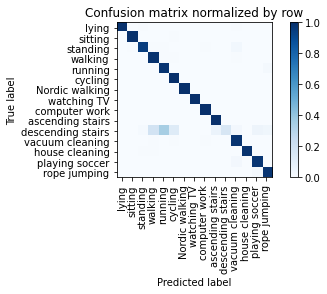

Overall accuracy: 0.957



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

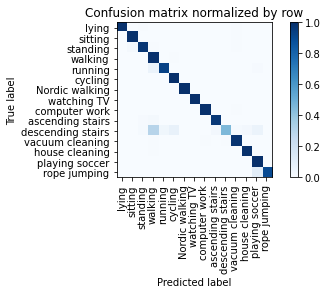

Overall accuracy: 0.965



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

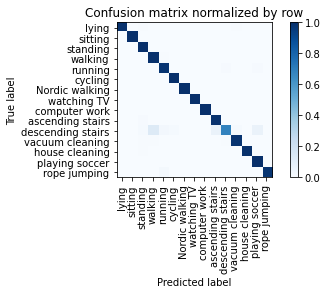

Overall accuracy: 0.983



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

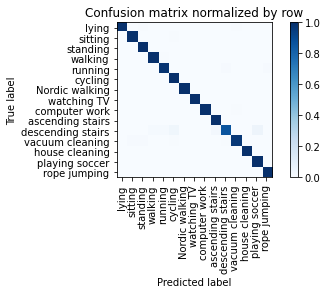

Overall accuracy: 0.988



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

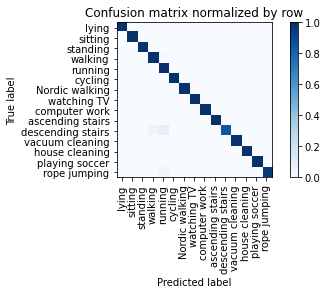

Overall accuracy: 0.990



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

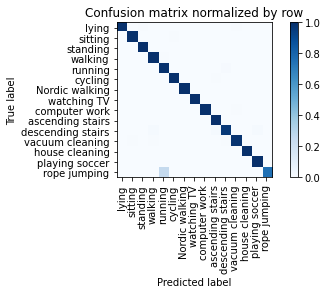

Overall accuracy: 0.988



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

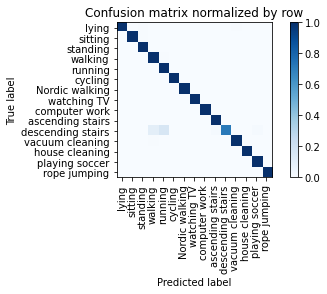

Overall accuracy: 0.986



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

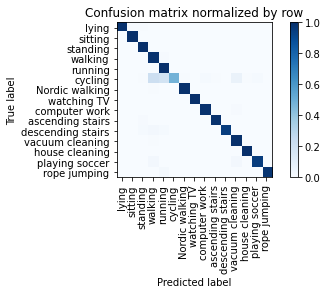

Overall accuracy: 0.958



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

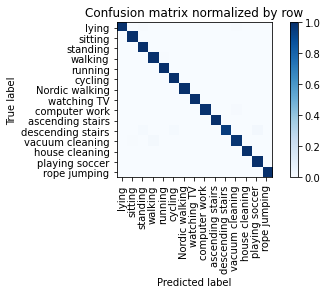

Overall accuracy: 0.993



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

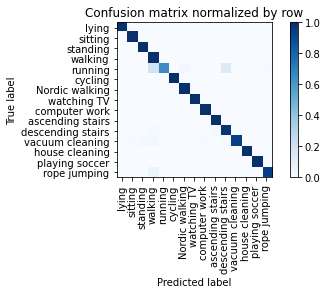

Overall accuracy: 0.974



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

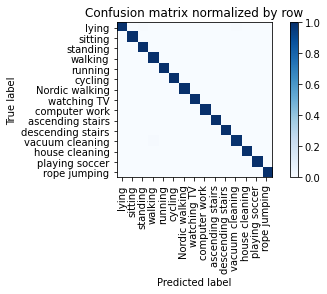

Overall accuracy: 0.998



train:   0%|          | 0/610 [00:00<?, ?batch/s]

seen:   0%|          | 0/67 [00:00<?, ?batch/s]

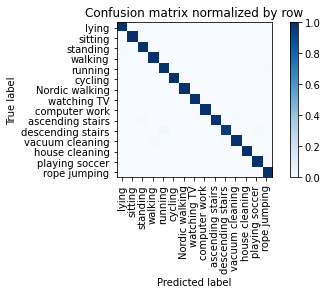

Overall accuracy: 0.993



unseen:   0%|          | 0/117 [00:00<?, ?batch/s]

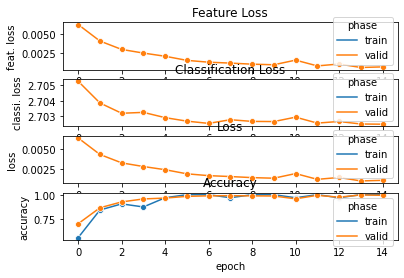

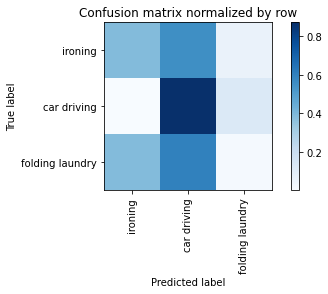

Overall accuracy: 0.360

{'accuracy': 0.36030982905982906, 'precision': 0.3258698189334252, 'recall': 0.42473449591689066, 'f1': 0.28428643218846483, 'samples': 3744, 'loss': 45.84609693288803, 'feat. loss': 45.43474692106247, 'classi. loss': 4113.501598358154}
============== Overall Unseen Classes Performance ==============
accuracy           0.354758
precision          0.385559
recall             0.363186
f1                 0.266695
samples         5075.200000
loss              64.336408
feat. loss        63.678565
classi. loss    6578.435227
dtype: float64
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 16 operations to synchronize with Neptune. Do not kill this process.
All 16 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-54/metadata


In [24]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()
